In [1]:
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime
from lxml import etree
from warnings import simplefilter
from prettytable import PrettyTable

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
simplefilter('ignore')

In [2]:
def dprint(*val, sep=' ', end='\n', flush=False):
    print(datetime.now().strftime('[%H:%M:%S]'), *val, sep=sep, end=end, flush=flush)

In [3]:
def extract_fd(datapath='data/fd'):
    all_files = sorted(os.listdir(datapath))
    row_index = 0

    skipped = []
    no_stat = []
    all_factors = {}

    for filename in all_files:
        if filename.count('_') == 3:
            skipped.append(filename)
            continue
            
        dprint(' '*50, end='\r')
        dprint(f'Opening   {filename}', end='\r')
        with open('data/fd/' + filename, encoding='utf-8') as fobj:
            xml = fobj.read()
        root = etree.fromstring(xml.encode('utf-8'))
        
        dprint(f'Handling  {filename}', end='\r')
        # ----------------------- Package -------- Appraise -------------
        estates = root.getchildren()[1].getchildren()[2].getchildren()[0]
        if estates.tag == 'Statistical_Modelling':
            estates = estates.getchildren()[0].getchildren()[1].getchildren()
            est_ind = 0
            all_est = len(estates)
            for real_estate in estates:
                if est_ind % 1000 == 0:
                    # dprint(f'Handling  {filename} - {est_ind} / {all_est}', end='\r')
                    pass
                est_ind += 1
                real_estate = real_estate.getchildren()
                cad_num = real_estate[0].text

                if cad_num in all_factors:
                    dprint()
                    dprint(f'Cadastral {cad_num} already in factors')
                else:
                    all_factors[cad_num] = {}

                for factor in real_estate[6].getchildren():
                    factor_id = int(factor.attrib['ID_Factor'])
                    value = float(factor.getchildren()[0].text)
                    all_factors[cad_num][factor_id] = value

        else:
            no_stat.append(filename)
        
    return all_factors

RELOAD_FACT = False

if RELOAD_FACT:
    dprint('Beginning factors extraction...')
    kadastr_fact = extract_fd()
    dprint(' '*1000, end='\r', flush=True)
    dprint(f'Factors data extracted, kadastr ids count: {len(kadastr_fact.keys())}')
    
    dprint('Saving kadastr_fact to json...', end='\r')
    with open('data/kadastr_fact.json', 'w') as jsfile:
        json.dump(kadastr_cost, jsfile)
    dprint('Cost data saved to data/kadastr_fact.json')
else:
    dprint('Loading kadastr_fact data...', end='\r')
    with open('data/kadastr_fact.json') as jsfile:
        kadastr_fact = json.load(jsfile)
    dprint('Data kadastr_fact was loaded from json')

[09:01:04] Data kadastr_fact was loaded from json


In [4]:
def extract_cost(datapath='data/cost'):
    all_files = os.listdir(datapath)
    
    kadastr_cost = {}
    row_index = 0
    for filename in all_files:
#         dprint(f'Opening   {filename}', end='\r')
        with open('data/cost/'+filename, encoding='utf-8') as fobj:
            xml = fobj.read()[1:]
        
        root = etree.fromstring(xml.encode('utf-8'))
        parsels = root.getchildren()[1]

        for i in range(8):
            parsels = parsels.getchildren()[0]

        parsels = parsels.getchildren()
        
        dprint(' '*100, end='\r')
        dprint(f'Handling  {filename.split()[-1]}', end='\r')
        for parsel in parsels:
            cad_number = parsel.attrib['CadastralNumber']
            ground_pay = parsel.getchildren()[0].getchildren()
            cadcost_m2 = ground_pay[0].attrib['Value']
            cadcost_m2_unit = ground_pay[0].attrib['Unit']
            cadcost = ground_pay[1].attrib['Value']
            cadcost_unit = ground_pay[1].attrib['Unit']
            kadastr_cost[cad_number] = [cadcost_m2, cadcost_m2_unit, cadcost, cadcost_unit]
            row_index += 1
    
    return kadastr_cost

RELOAD_COST = False

if RELOAD_COST:
    dprint('Beginning cost extraction...')
    kadastr_cost = extract_cost()
    print(' '*100, end='\r')
    dprint(f'Cost data extracted, kadastr ids count: {len(kadastr_cost.keys())}')
    
    dprint('Saving kadastr_cost to json...', end='\r')
    with open('data/kadastr_cost.json', 'w') as jsfile:
        json.dump(kadastr_cost, jsfile)
    dprint('Cost data saved to data/kadastr_cost.json')  
else:
    dprint('Loading kadastr_cost data...', end='\r')
    with open('data/kadastr_cost.json') as jsfile:
        kadastr_cost = json.load(jsfile)
    dprint('Data kadastr_cost was loaded from json')

[09:01:04] Data kadastr_cost was loaded from json


In [5]:
def extract_fac_desc():
    with open('data/fd/FD_GKO_7.xml', encoding='utf-8') as fobj:
            xml = fobj.read()[1:]

    root = etree.fromstring(xml.encode('utf-8'))
    evfac = root.getchildren()[1].getchildren()[1].getchildren()

    fac_desc = {}
    for fac in evfac:
        fac_id = fac.attrib['Id_Factor']
        fac_name = fac.getchildren()[0].text
        fac_name = fac_name.replace('_', ' ').strip()
        fac_desc[int(fac_id)] = fac_name
        
    return fac_desc

RELOAD_DESC = False
if RELOAD_DESC:
    fac_desc = extract_fac_desc()
    with open('data/fac_desc.json', 'w', encoding='windows-1251') as file:
        json.dump(fac_desc, file, ensure_ascii=False)
else:
    # Or shorten
    with open('data/fac_desc_short.json', encoding='utf-8') as file:
        fac_desc = json.loads(file.read())
        fac_desc = {int(key): f'({key}) {val}' for key, val in fac_desc.items()}
    dprint('Factors shotrs loaded')

[09:01:05] Factors shotrs loaded


In [6]:
data_columns = ['KadastrId'] + list(range(0, 62)) + ['Cost', 'Cost unit', 'Cost m2', 'Cost m2 unit']

kadid_full = set(kadastr_cost.keys()) & set(kadastr_fact.keys())

# data = {}
# data_row = dict([(key, np.nan) for key in data_columns])

# for index, kadid in enumerate(kadid_full):
#     new_row = data_row.copy()
#     new_row.update(kadastr_fact[kadid])
#     kadcost_m2, kadcost_m2_unit, kadcost, kadcost_unit = kadastr_cost[kadid]
#     new_row['Cost'] = kadcost
#     new_row['Cost unit'] = kadcost_unit
#     new_row['Cost m2'] = kadcost_m2
#     new_row['Cost m2 unit'] = kadcost_m2_unit
#     data[kadid] = new_row

data = dict([(key, {}) for key in data_columns])
for index, kadid in enumerate(kadid_full):
    data['KadastrId'][kadid] = kadid
    for key, val in kadastr_fact[kadid].items():
        data[int(key)][kadid] = val
    kadcost_m2, kadcost_m2_unit, kadcost, kadcost_unit = kadastr_cost[kadid]
    data['Cost'][kadid] = kadcost
    data['Cost unit'][kadid] = kadcost_unit
    data['Cost m2'][kadid] = float(kadcost_m2)
    data['Cost m2 unit'][kadid] = kadcost_m2_unit

In [7]:
data = pd.DataFrame(data).set_index('KadastrId')
print(data.shape)
data.head()

(24540, 66)


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,Cost,Cost unit,Cost m2,Cost m2 unit
KadastrId,,,,,,,,,,,,,,,,,,,,,
21:01:000000:10367,NaN,NaN,2.0,5.0,NaN,37.0,NaN,40.0,NaN,NaN,...,11188.0,NaN,NaN,NaN,NaN,NaN,934537.12,383,20449.39,1002
21:01:000000:10368,NaN,NaN,2.0,5.0,NaN,37.0,NaN,38.0,NaN,NaN,...,11188.0,NaN,NaN,NaN,NaN,NaN,494878.12,383,21516.44,1002
21:01:000000:10372,NaN,NaN,2.0,5.0,NaN,37.0,NaN,38.0,NaN,NaN,...,11188.0,NaN,NaN,NaN,NaN,NaN,800411.57,383,21516.44,1002
21:01:000000:10373,NaN,NaN,2.0,5.0,NaN,37.0,NaN,40.0,NaN,NaN,...,11188.0,NaN,NaN,NaN,NaN,NaN,959076.39,383,20449.39,1002
21:01:000000:10374,NaN,NaN,2.0,5.0,NaN,37.0,NaN,38.0,NaN,NaN,...,11188.0,NaN,NaN,NaN,NaN,NaN,811169.79,383,21516.44,1002


In [8]:
data.rename(columns=fac_desc, inplace=True)
data.head()

,(0) Близость к водным объектам,(1) Кадастровая стоимость предыдущего тура,(2) Материал стен 1 группа,(3) Материал стен КС,(4) Микрорайон г.Новочебоксарск,(5) Микрорайон г.Чебоксары,(6) Номер группы пред.тура,(7) Площадь 1 группа,(8) Подгруппа 1 группа,(9) Районы города,...,(56) Код КЛАДР улицы,(57) СНП Центр сельского поселения,(58) Площадь 2 группа,(59) Материал стен 2 группа,(60) Код подгруппы,(61) Подгруппа 2 группа,Cost,Cost unit,Cost m2,Cost m2 unit
KadastrId,,,,,,,,,,,,,,,,,,,,,
21:01:000000:10367,NaN,NaN,2.0,5.0,NaN,37.0,NaN,40.0,NaN,NaN,...,11188.0,NaN,NaN,NaN,NaN,NaN,934537.12,383,20449.39,1002
21:01:000000:10368,NaN,NaN,2.0,5.0,NaN,37.0,NaN,38.0,NaN,NaN,...,11188.0,NaN,NaN,NaN,NaN,NaN,494878.12,383,21516.44,1002
21:01:000000:10372,NaN,NaN,2.0,5.0,NaN,37.0,NaN,38.0,NaN,NaN,...,11188.0,NaN,NaN,NaN,NaN,NaN,800411.57,383,21516.44,1002
21:01:000000:10373,NaN,NaN,2.0,5.0,NaN,37.0,NaN,40.0,NaN,NaN,...,11188.0,NaN,NaN,NaN,NaN,NaN,959076.39,383,20449.39,1002
21:01:000000:10374,NaN,NaN,2.0,5.0,NaN,37.0,NaN,38.0,NaN,NaN,...,11188.0,NaN,NaN,NaN,NaN,NaN,811169.79,383,21516.44,1002


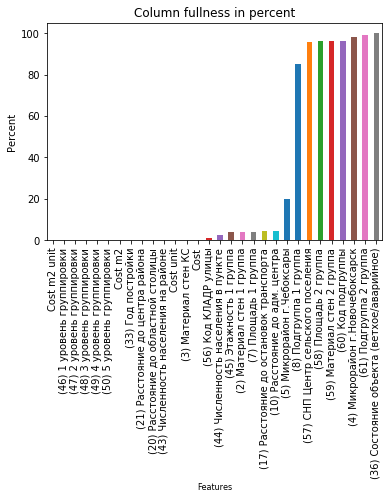

In [9]:
f, ax = plt.subplots()
ax.set_xlabel('xlabel', fontsize=8)
plt.xlabel("Features")
plt.ylabel("Percent")

non_data = pd.Series(data.isnull().sum()/data.shape[0]*100).sort_values()

to_drop = []
for column in non_data.index:
    if non_data[column] == 100.0:
        to_drop.append(column)

non_data.drop(labels=to_drop, inplace=True)
non_data.plot("bar", title="Сolumn fullness in percent");

In [10]:
# to_drop = ["Cost m2 unit", "Cost unit", "43", "44", "CadastralNumber"]
to_drop = ["Cost m2 unit", "Cost unit", 'Cost']
print("Before -",data.shape)
for column in data.columns:
    if data[column].isnull().sum() > data.shape[0] * 0.4 or len(data[column].unique()) == 1:
        to_drop.append(column)

pdata = data.drop(to_drop, axis=1).dropna()

to_drop = []
for column in pdata.columns:
    if len(pdata[column].unique()) == 1:
        to_drop.append(column)
pdata = pdata.drop(to_drop, axis=1).dropna()   

print(pdata.isna().sum())
print("After -", pdata.shape)

Before - (24540, 66)
(2) Материал стен 1 группа                 0
(3) Материал стен КС                       0
(5) Микрорайон г.Чебоксары                 0
(7) Площадь 1 группа                       0
(10) Расстояние до адм. центра             0
(17) Расстояние до остановок транспорта    0
(33) Год постройки                         0
(45) Этажность 1 группа                    0
(56) Код КЛАДР улицы                       0
Cost m2                                    0
dtype: int64
After - (19594, 10)


In [11]:
table = PrettyTable(['Column', 'Unique'])
for column in pdata.columns:
    unq = pdata[column].unique()
    if len(unq) < 10:
        table.add_row([column, unq])
    else:
        table.add_row([column, 'Many uniques'])
        
print(table)

+-----------------------------------------+-------------------------------+
|                  Column                 |             Unique            |
+-----------------------------------------+-------------------------------+
|        (2) Материал стен 1 группа       |            [2. 1.]            |
|           (3) Материал стен КС          |            [5. 3.]            |
|        (5) Микрорайон г.Чебоксары       | [37. 30. 33. 31. 35. 34. 32.] |
|           (7) Площадь 1 группа          |       [40. 38. 41. 39.]       |
|      (10) Расстояние до адм. центра     |          Many uniques         |
| (17) Расстояние до остановок транспорта |          Many uniques         |
|            (33) Год постройки           |          Many uniques         |
|         (45) Этажность 1 группа         |     [105. 102. 103. 104.]     |
|           (56) Код КЛАДР улицы          |          Many uniques         |
|                 Cost m2                 |          Many uniques         |
+-----------

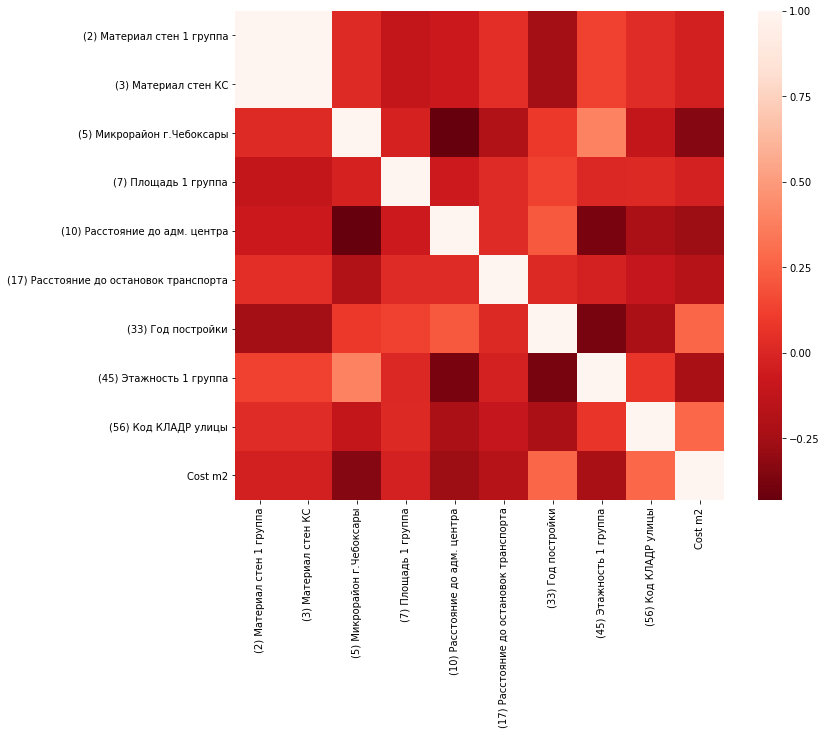

In [12]:
colors = """ Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r"""
colors = colors.strip().split(', ')

colors = [colors[55]]

for clr in colors:
    corrmat = pdata.corr()
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, square=True, cmap=clr);

In [13]:
pdata.drop('(2) Материал стен 1 группа', axis = 1, inplace = True)

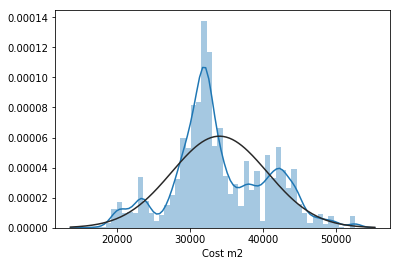

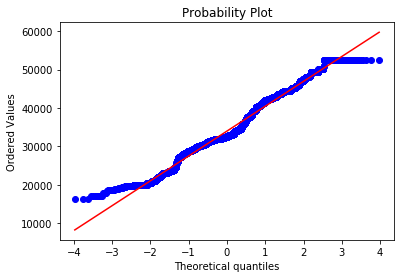

In [14]:
sns.distplot(pdata['Cost m2'], fit=norm);
fig = plt.figure()
# f, ax = plt.subplots(figsize=(12, 9))
colres = stats.probplot(pdata['Cost m2'], plot=plt);

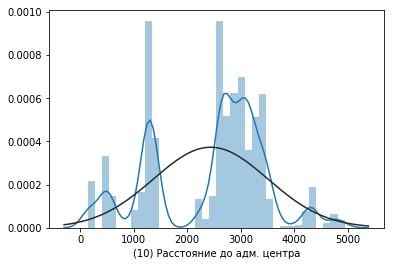

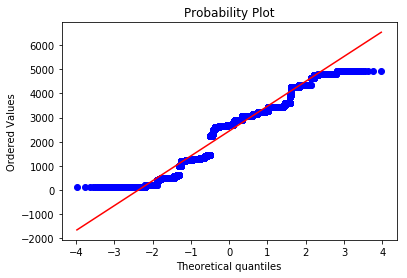

In [15]:
col = '(10) Расстояние до адм. центра'

sns.distplot(pdata[col], fit=norm);
fig = plt.figure()
# f, ax = plt.subplots(figsize=(12, 9))
res = stats.probplot(pdata[col], plot=plt);

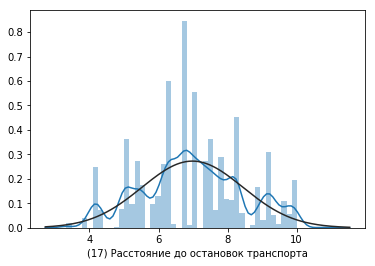

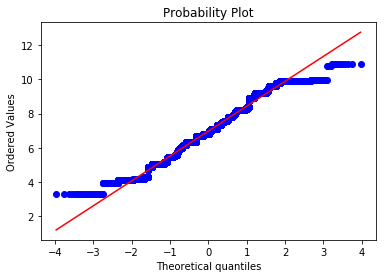

In [16]:
col = '(17) Расстояние до остановок транспорта'

ppdata = pdata.copy()
ppdata[col] = stats.boxcox(ppdata[col], 0.15)  # WOW!!!!

sns.distplot(ppdata[col], fit=norm);
fig = plt.figure()
# f, ax = plt.subplots(figsize=(12, 9))
res = stats.probplot(ppdata[col], plot=plt);

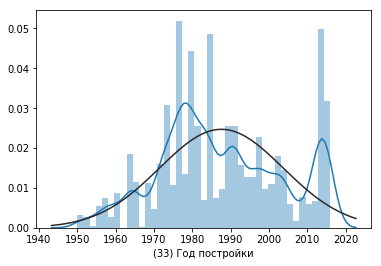

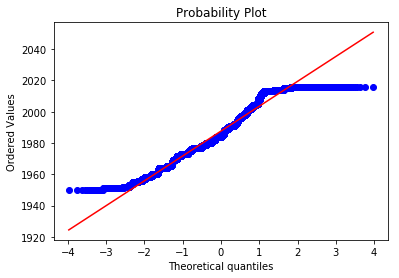

In [17]:
col = '(33) Год постройки'

sns.distplot(pdata[col], fit=norm);
fig = plt.figure()
# f, ax = plt.subplots(figsize=(12, 9))
res = stats.probplot(pdata[col], plot=plt);

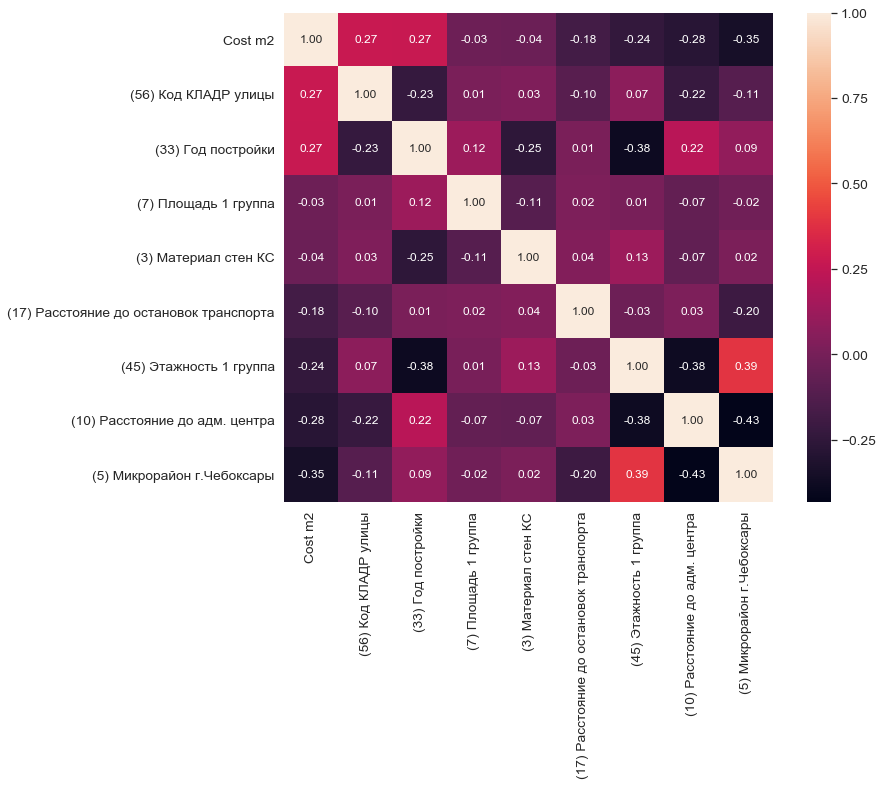

In [20]:
k = 10 #number of variables for heatmap

corrmat = pdata.corr()
cols = corrmat.nlargest(k, 'Cost m2')['Cost m2'].index

cm = np.corrcoef(pdata[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()